## Training and Quality control for nuclear segmentation

StarDist uses a shape representation based on star-convex polygons for nuclei in an image to predict the presence and the shape of these nuclei. This network is based on an adapted U-Net network architecture. 

To train and test the network, we use a dataset from the 2018 DSB nuclear segmentation challenge as well as few more nuclei that we have labelled from widefield images of DAPI stained tissue sections.

In [1]:
# import libraries 
import sys
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import imageio as imio
import os

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.utils.tf import limit_gpu_memory

from stardist import fill_label_holes, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D

from src.utlis.data_augmentation import augmenter

from src.utlis.segmentation_stardist_model import segment_objects_stardist2d
from stardist.matching import matching_dataset


In [2]:
# setup the paths 
path_to_ground_truth_data= '/media/pathy_s/54fe7289-2a61-4f3a-ac84-eeea3c0d1d2f/codebase/nuclear_segmentation/ground_truths/tissue_nuclear_segmentation_2021/' 
path_to_raw_image = os.path.join(path_to_ground_truth_data,'raw_train/')
path_to_GT_labels = os.path.join(path_to_ground_truth_data,'GT_train/')
path_to_raw_image_test = os.path.join(path_to_ground_truth_data,'raw_test/') 
path_to_GT_labels_test = os.path.join(path_to_ground_truth_data,'GT_test/')

path_to_model = '/media/pathy_s/54fe7289-2a61-4f3a-ac84-eeea3c0d1d2f/codebase/nuclear_segmentation/models/'
output_dir = os.path.join(path_to_ground_truth_data,'model_pred_tissue_nuclear_segmentation_2021/')

path_to_output_segmented_images_train = os.path.join(path_to_ground_truth_data,'segmented_labels_train/')
path_to_output_segmented_images_test = os.path.join(path_to_ground_truth_data,'segmented_labels_test/')

Path(output_dir).mkdir(parents=True, exist_ok=True)
Path(path_to_output_segmented_images_train).mkdir(parents=True, exist_ok=True)
Path(path_to_output_segmented_images_test).mkdir(parents=True, exist_ok=True)

In [3]:
#read in the training data which would of pairs of input image and label instances.
X = sorted(glob(path_to_raw_image +'*.tif'))
Y = sorted(glob(path_to_GT_labels +'*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))
X = list(map(imread,X))
Y = list(map(imread,Y))
#Normalize images and fill small label holes.
X = [normalize(x,1,99.8,axis=(0,1)) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]
#Split into train and validation datasets.
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

100%|██████████| 457/457 [00:03<00:00, 138.49it/s]

number of images: 457
- training:       388
- validation:      69


In [4]:
#set up the configuration
conf = Config2D (
    n_rays       = 32,
    grid         = (2,2),
    use_gpu      = False and gputools_available(),
    n_channel_in = 1)
limit_gpu_memory(None, allow_growth=True)

#Setup and train the model
model = StarDist2D(conf, name='tissue_nuclear_segmentation_2021', basedir=path_to_model)
history=model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)
#optimize NMS threshold
model.optimize_thresholds(X_val, Y_val)
# convert the history.history dict to a pandas DataFrame:     
lossData = pd.DataFrame(history.history) 

/home/pathy_s/anaconda3/lib/python3.8/site-packages/csbdeep/models/base_model.py:148: UserWarning: output path for model already exists, files may be overwritten: /media/pathy_s/54fe7289-2a61-4f3a-ac84-eeea3c0d1d2f/codebase/nuclear_segmentation/models/tissue_nuclear_segmentation_2021
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


Using default values: prob_thresh=0.5, nms_thresh=0.4.
Epoch 1/400
100/100 [==============================] - 15s 146ms/step - loss: 2.5887 - prob_loss: 0.3679 - dist_loss: 11.1044 - prob_kld: 0.2898 - dist_relevant_mae: 11.1040 - dist_relevant_mse: 231.3112 - val_loss: 2.0526 - val_prob_loss: 0.2545 - val_dist_loss: 8.9908 - val_prob_kld: 0.1839 - val_dist_relevant_mae: 8.9902 - val_dist_relevant_mse: 174.1434
Epoch 2/400
100/100 [==============================] - 12s 119ms/step - loss: 1.7090 - prob_loss: 0.2681 - dist_loss: 7.2043 - prob_kld: 0.1935 - dist_relevant_mae: 7.2034 - dist_relevant_mse: 108.0598 - val_loss: 1.6329 - val_prob_loss: 0.2707 - val_dist_loss: 6.8110 - val_prob_kld: 0.2001 - val_dist_relevant_mae: 6.8102 - val_dist_relevant_mse: 105.4105
Epoch 3/400
100/100 [==============================] - 12s 120ms/step - loss: 1.5398 - prob_loss: 0.2267 - dist_loss: 6.5656 - prob_kld: 0.1522 - dist_relevant_mae: 6.5645 - dist_relevant_mse: 93.5023 - val_loss: 1.4183 - val_p

Epoch 24/400
100/100 [==============================] - 11s 112ms/step - loss: 0.5789 - prob_loss: 0.0928 - dist_loss: 2.4306 - prob_kld: 0.0163 - dist_relevant_mae: 2.4299 - dist_relevant_mse: 17.6468 - val_loss: 0.6113 - val_prob_loss: 0.0842 - val_dist_loss: 2.6356 - val_prob_kld: 0.0136 - val_dist_relevant_mae: 2.6349 - val_dist_relevant_mse: 21.6229
Epoch 25/400
100/100 [==============================] - 12s 117ms/step - loss: 0.5376 - prob_loss: 0.0899 - dist_loss: 2.2385 - prob_kld: 0.0176 - dist_relevant_mae: 2.2379 - dist_relevant_mse: 14.5019 - val_loss: 0.6398 - val_prob_loss: 0.0832 - val_dist_loss: 2.7834 - val_prob_kld: 0.0125 - val_dist_relevant_mae: 2.7828 - val_dist_relevant_mse: 24.7745
Epoch 26/400
100/100 [==============================] - 12s 115ms/step - loss: 0.5495 - prob_loss: 0.0891 - dist_loss: 2.3021 - prob_kld: 0.0148 - dist_relevant_mae: 2.3014 - dist_relevant_mse: 15.4288 - val_loss: 0.5740 - val_prob_loss: 0.0835 - val_dist_loss: 2.4524 - val_prob_kld: 0

Epoch 47/400
100/100 [==============================] - 12s 117ms/step - loss: 0.4607 - prob_loss: 0.0873 - dist_loss: 1.8669 - prob_kld: 0.0129 - dist_relevant_mae: 1.8663 - dist_relevant_mse: 10.3648 - val_loss: 0.4973 - val_prob_loss: 0.0829 - val_dist_loss: 2.0719 - val_prob_kld: 0.0123 - val_dist_relevant_mae: 2.0714 - val_dist_relevant_mse: 15.1397
Epoch 48/400
100/100 [==============================] - 11s 114ms/step - loss: 0.4574 - prob_loss: 0.0875 - dist_loss: 1.8492 - prob_kld: 0.0121 - dist_relevant_mae: 1.8486 - dist_relevant_mse: 9.7264 - val_loss: 0.4700 - val_prob_loss: 0.0816 - val_dist_loss: 1.9419 - val_prob_kld: 0.0110 - val_dist_relevant_mae: 1.9413 - val_dist_relevant_mse: 12.9088
Epoch 49/400
100/100 [==============================] - 11s 114ms/step - loss: 0.4422 - prob_loss: 0.0855 - dist_loss: 1.7833 - prob_kld: 0.0122 - dist_relevant_mae: 1.7827 - dist_relevant_mse: 9.9583 - val_loss: 0.5348 - val_prob_loss: 0.0820 - val_dist_loss: 2.2643 - val_prob_kld: 0.0

Epoch 70/400
100/100 [==============================] - 12s 116ms/step - loss: 0.4154 - prob_loss: 0.0868 - dist_loss: 1.6431 - prob_kld: 0.0119 - dist_relevant_mae: 1.6426 - dist_relevant_mse: 8.3244 - val_loss: 0.5053 - val_prob_loss: 0.0825 - val_dist_loss: 2.1139 - val_prob_kld: 0.0119 - val_dist_relevant_mae: 2.1135 - val_dist_relevant_mse: 13.1410
Epoch 71/400
100/100 [==============================] - 11s 115ms/step - loss: 0.4341 - prob_loss: 0.0861 - dist_loss: 1.7400 - prob_kld: 0.0119 - dist_relevant_mae: 1.7395 - dist_relevant_mse: 9.0236 - val_loss: 0.4463 - val_prob_loss: 0.0812 - val_dist_loss: 1.8259 - val_prob_kld: 0.0105 - val_dist_relevant_mae: 1.8254 - val_dist_relevant_mse: 12.2778
Epoch 72/400
100/100 [==============================] - 12s 118ms/step - loss: 0.4177 - prob_loss: 0.0860 - dist_loss: 1.6582 - prob_kld: 0.0107 - dist_relevant_mae: 1.6577 - dist_relevant_mse: 8.1484 - val_loss: 0.4457 - val_prob_loss: 0.0809 - val_dist_loss: 1.8240 - val_prob_kld: 0.01

100/100 [==============================] - 11s 114ms/step - loss: 0.4084 - prob_loss: 0.0885 - dist_loss: 1.5994 - prob_kld: 0.0135 - dist_relevant_mae: 1.5988 - dist_relevant_mse: 8.3175 - val_loss: 0.4200 - val_prob_loss: 0.0822 - val_dist_loss: 1.6889 - val_prob_kld: 0.0116 - val_dist_relevant_mae: 1.6883 - val_dist_relevant_mse: 10.5818
Epoch 94/400
100/100 [==============================] - 12s 119ms/step - loss: 0.3930 - prob_loss: 0.0844 - dist_loss: 1.5430 - prob_kld: 0.0103 - dist_relevant_mae: 1.5424 - dist_relevant_mse: 7.4059 - val_loss: 0.4251 - val_prob_loss: 0.0823 - val_dist_loss: 1.7142 - val_prob_kld: 0.0117 - val_dist_relevant_mae: 1.7137 - val_dist_relevant_mse: 10.8763
Epoch 95/400
100/100 [==============================] - 12s 121ms/step - loss: 0.4069 - prob_loss: 0.0860 - dist_loss: 1.6043 - prob_kld: 0.0110 - dist_relevant_mae: 1.6038 - dist_relevant_mse: 7.8518 - val_loss: 0.4243 - val_prob_loss: 0.0810 - val_dist_loss: 1.7161 - val_prob_kld: 0.0104 - val_dist

100/100 [==============================] - 11s 113ms/step - loss: 0.3763 - prob_loss: 0.0836 - dist_loss: 1.4634 - prob_kld: 0.0103 - dist_relevant_mae: 1.4630 - dist_relevant_mse: 6.5264 - val_loss: 0.4260 - val_prob_loss: 0.0807 - val_dist_loss: 1.7266 - val_prob_kld: 0.0101 - val_dist_relevant_mae: 1.7261 - val_dist_relevant_mse: 11.0300
Epoch 117/400
100/100 [==============================] - 11s 112ms/step - loss: 0.3962 - prob_loss: 0.0835 - dist_loss: 1.5637 - prob_kld: 0.0106 - dist_relevant_mae: 1.5632 - dist_relevant_mse: 7.3909 - val_loss: 0.4486 - val_prob_loss: 0.0808 - val_dist_loss: 1.8393 - val_prob_kld: 0.0102 - val_dist_relevant_mae: 1.8388 - val_dist_relevant_mse: 11.9962
Epoch 118/400
100/100 [==============================] - 12s 117ms/step - loss: 0.4062 - prob_loss: 0.0895 - dist_loss: 1.5832 - prob_kld: 0.0129 - dist_relevant_mae: 1.5827 - dist_relevant_mse: 7.7109 - val_loss: 0.4411 - val_prob_loss: 0.0806 - val_dist_loss: 1.8028 - val_prob_kld: 0.0099 - val_di

Epoch 139/400
100/100 [==============================] - 11s 112ms/step - loss: 0.3581 - prob_loss: 0.0801 - dist_loss: 1.3901 - prob_kld: 0.0102 - dist_relevant_mae: 1.3897 - dist_relevant_mse: 6.0503 - val_loss: 0.4227 - val_prob_loss: 0.0807 - val_dist_loss: 1.7096 - val_prob_kld: 0.0101 - val_dist_relevant_mae: 1.7092 - val_dist_relevant_mse: 10.9628
Epoch 140/400
100/100 [==============================] - 11s 111ms/step - loss: 0.4002 - prob_loss: 0.0895 - dist_loss: 1.5538 - prob_kld: 0.0112 - dist_relevant_mae: 1.5533 - dist_relevant_mse: 7.4261 - val_loss: 0.4315 - val_prob_loss: 0.0816 - val_dist_loss: 1.7494 - val_prob_kld: 0.0110 - val_dist_relevant_mae: 1.7488 - val_dist_relevant_mse: 11.4013
Epoch 141/400
100/100 [==============================] - 11s 115ms/step - loss: 0.3718 - prob_loss: 0.0856 - dist_loss: 1.4308 - prob_kld: 0.0101 - dist_relevant_mae: 1.4303 - dist_relevant_mse: 6.4287 - val_loss: 0.4278 - val_prob_loss: 0.0815 - val_dist_loss: 1.7319 - val_prob_kld: 0

Epoch 162/400
100/100 [==============================] - 11s 113ms/step - loss: 0.3616 - prob_loss: 0.0838 - dist_loss: 1.3891 - prob_kld: 0.0096 - dist_relevant_mae: 1.3887 - dist_relevant_mse: 6.0200 - val_loss: 0.4105 - val_prob_loss: 0.0805 - val_dist_loss: 1.6500 - val_prob_kld: 0.0099 - val_dist_relevant_mae: 1.6496 - val_dist_relevant_mse: 9.6686
Epoch 163/400
100/100 [==============================] - 12s 115ms/step - loss: 0.3604 - prob_loss: 0.0838 - dist_loss: 1.3832 - prob_kld: 0.0100 - dist_relevant_mae: 1.3827 - dist_relevant_mse: 6.1306 - val_loss: 0.4279 - val_prob_loss: 0.0818 - val_dist_loss: 1.7304 - val_prob_kld: 0.0112 - val_dist_relevant_mae: 1.7298 - val_dist_relevant_mse: 10.2845
Epoch 164/400
100/100 [==============================] - 11s 115ms/step - loss: 0.3726 - prob_loss: 0.0857 - dist_loss: 1.4346 - prob_kld: 0.0097 - dist_relevant_mae: 1.4341 - dist_relevant_mse: 6.3955 - val_loss: 0.4071 - val_prob_loss: 0.0820 - val_dist_loss: 1.6257 - val_prob_kld: 0.

Epoch 185/400
100/100 [==============================] - 11s 112ms/step - loss: 0.3663 - prob_loss: 0.0853 - dist_loss: 1.4051 - prob_kld: 0.0099 - dist_relevant_mae: 1.4047 - dist_relevant_mse: 6.5771 - val_loss: 0.3931 - val_prob_loss: 0.0804 - val_dist_loss: 1.5639 - val_prob_kld: 0.0097 - val_dist_relevant_mae: 1.5635 - val_dist_relevant_mse: 9.3573
Epoch 186/400
100/100 [==============================] - 12s 117ms/step - loss: 0.3556 - prob_loss: 0.0839 - dist_loss: 1.3584 - prob_kld: 0.0094 - dist_relevant_mae: 1.3579 - dist_relevant_mse: 6.1981 - val_loss: 0.3993 - val_prob_loss: 0.0803 - val_dist_loss: 1.5948 - val_prob_kld: 0.0097 - val_dist_relevant_mae: 1.5944 - val_dist_relevant_mse: 9.8503
Epoch 187/400
100/100 [==============================] - 11s 113ms/step - loss: 0.3535 - prob_loss: 0.0816 - dist_loss: 1.3596 - prob_kld: 0.0088 - dist_relevant_mae: 1.3592 - dist_relevant_mse: 5.8824 - val_loss: 0.3972 - val_prob_loss: 0.0805 - val_dist_loss: 1.5832 - val_prob_kld: 0.0

Epoch 208/400
100/100 [==============================] - 12s 116ms/step - loss: 0.3331 - prob_loss: 0.0795 - dist_loss: 1.2682 - prob_kld: 0.0098 - dist_relevant_mae: 1.2678 - dist_relevant_mse: 5.2429 - val_loss: 0.3825 - val_prob_loss: 0.0811 - val_dist_loss: 1.5069 - val_prob_kld: 0.0105 - val_dist_relevant_mae: 1.5064 - val_dist_relevant_mse: 9.1040
Epoch 209/400
100/100 [==============================] - 12s 119ms/step - loss: 0.3672 - prob_loss: 0.0884 - dist_loss: 1.3939 - prob_kld: 0.0095 - dist_relevant_mae: 1.3934 - dist_relevant_mse: 6.2781 - val_loss: 0.3927 - val_prob_loss: 0.0806 - val_dist_loss: 1.5605 - val_prob_kld: 0.0100 - val_dist_relevant_mae: 1.5601 - val_dist_relevant_mse: 9.7765
Epoch 210/400
100/100 [==============================] - 12s 115ms/step - loss: 0.3470 - prob_loss: 0.0804 - dist_loss: 1.3326 - prob_kld: 0.0093 - dist_relevant_mae: 1.3322 - dist_relevant_mse: 5.6336 - val_loss: 0.3958 - val_prob_loss: 0.0820 - val_dist_loss: 1.5690 - val_prob_kld: 0.0

Epoch 231/400
100/100 [==============================] - 11s 111ms/step - loss: 0.3357 - prob_loss: 0.0837 - dist_loss: 1.2603 - prob_kld: 0.0088 - dist_relevant_mae: 1.2599 - dist_relevant_mse: 5.1696 - val_loss: 0.3843 - val_prob_loss: 0.0804 - val_dist_loss: 1.5195 - val_prob_kld: 0.0097 - val_dist_relevant_mae: 1.5191 - val_dist_relevant_mse: 9.5021
Epoch 232/400
100/100 [==============================] - 12s 117ms/step - loss: 0.3442 - prob_loss: 0.0846 - dist_loss: 1.2978 - prob_kld: 0.0101 - dist_relevant_mae: 1.2973 - dist_relevant_mse: 6.1280 - val_loss: 0.3949 - val_prob_loss: 0.0813 - val_dist_loss: 1.5679 - val_prob_kld: 0.0107 - val_dist_relevant_mae: 1.5672 - val_dist_relevant_mse: 10.0296
Epoch 233/400
100/100 [==============================] - 12s 117ms/step - loss: 0.3479 - prob_loss: 0.0822 - dist_loss: 1.3284 - prob_kld: 0.0095 - dist_relevant_mae: 1.3280 - dist_relevant_mse: 6.0323 - val_loss: 0.4029 - val_prob_loss: 0.0825 - val_dist_loss: 1.6016 - val_prob_kld: 0.

Epoch 254/400
100/100 [==============================] - 11s 114ms/step - loss: 0.3362 - prob_loss: 0.0850 - dist_loss: 1.2558 - prob_kld: 0.0088 - dist_relevant_mae: 1.2554 - dist_relevant_mse: 5.2037 - val_loss: 0.4000 - val_prob_loss: 0.0807 - val_dist_loss: 1.5965 - val_prob_kld: 0.0101 - val_dist_relevant_mae: 1.5960 - val_dist_relevant_mse: 10.3225
Epoch 255/400
100/100 [==============================] - 12s 120ms/step - loss: 0.3345 - prob_loss: 0.0807 - dist_loss: 1.2691 - prob_kld: 0.0088 - dist_relevant_mae: 1.2687 - dist_relevant_mse: 5.5946 - val_loss: 0.3845 - val_prob_loss: 0.0803 - val_dist_loss: 1.5209 - val_prob_kld: 0.0097 - val_dist_relevant_mae: 1.5205 - val_dist_relevant_mse: 9.9306
Epoch 256/400
100/100 [==============================] - 12s 117ms/step - loss: 0.3298 - prob_loss: 0.0841 - dist_loss: 1.2284 - prob_kld: 0.0083 - dist_relevant_mae: 1.2279 - dist_relevant_mse: 5.3443 - val_loss: 0.3834 - val_prob_loss: 0.0802 - val_dist_loss: 1.5159 - val_prob_kld: 0.

100/100 [==============================] - 11s 113ms/step - loss: 0.3209 - prob_loss: 0.0820 - dist_loss: 1.1946 - prob_kld: 0.0085 - dist_relevant_mae: 1.1941 - dist_relevant_mse: 5.0493 - val_loss: 0.3741 - val_prob_loss: 0.0800 - val_dist_loss: 1.4709 - val_prob_kld: 0.0093 - val_dist_relevant_mae: 1.4704 - val_dist_relevant_mse: 9.0948
Epoch 277/400
100/100 [==============================] - 12s 116ms/step - loss: 0.3147 - prob_loss: 0.0823 - dist_loss: 1.1616 - prob_kld: 0.0080 - dist_relevant_mae: 1.1612 - dist_relevant_mse: 4.5265 - val_loss: 0.3822 - val_prob_loss: 0.0803 - val_dist_loss: 1.5098 - val_prob_kld: 0.0097 - val_dist_relevant_mae: 1.5094 - val_dist_relevant_mse: 9.4125
Epoch 278/400
100/100 [==============================] - 11s 114ms/step - loss: 0.3086 - prob_loss: 0.0813 - dist_loss: 1.1366 - prob_kld: 0.0085 - dist_relevant_mae: 1.1362 - dist_relevant_mse: 4.2332 - val_loss: 0.3784 - val_prob_loss: 0.0801 - val_dist_loss: 1.4918 - val_prob_kld: 0.0094 - val_dist

100/100 [==============================] - 11s 108ms/step - loss: 0.3170 - prob_loss: 0.0827 - dist_loss: 1.1715 - prob_kld: 0.0080 - dist_relevant_mae: 1.1711 - dist_relevant_mse: 5.0980 - val_loss: 0.3704 - val_prob_loss: 0.0799 - val_dist_loss: 1.4524 - val_prob_kld: 0.0093 - val_dist_relevant_mae: 1.4520 - val_dist_relevant_mse: 8.9188
Epoch 300/400
100/100 [==============================] - 11s 114ms/step - loss: 0.3095 - prob_loss: 0.0814 - dist_loss: 1.1409 - prob_kld: 0.0077 - dist_relevant_mae: 1.1405 - dist_relevant_mse: 4.4496 - val_loss: 0.3813 - val_prob_loss: 0.0808 - val_dist_loss: 1.5024 - val_prob_kld: 0.0102 - val_dist_relevant_mae: 1.5021 - val_dist_relevant_mse: 9.5428
Epoch 301/400
100/100 [==============================] - 11s 111ms/step - loss: 0.3004 - prob_loss: 0.0826 - dist_loss: 1.0894 - prob_kld: 0.0076 - dist_relevant_mae: 1.0890 - dist_relevant_mse: 3.9597 - val_loss: 0.3683 - val_prob_loss: 0.0798 - val_dist_loss: 1.4427 - val_prob_kld: 0.0091 - val_dist

100/100 [==============================] - 12s 115ms/step - loss: 0.3160 - prob_loss: 0.0836 - dist_loss: 1.1620 - prob_kld: 0.0079 - dist_relevant_mae: 1.1616 - dist_relevant_mse: 4.1819 - val_loss: 0.4391 - val_prob_loss: 0.0804 - val_dist_loss: 1.7935 - val_prob_kld: 0.0098 - val_dist_relevant_mae: 1.7931 - val_dist_relevant_mse: 10.3285
Epoch 323/400
100/100 [==============================] - 11s 115ms/step - loss: 0.3070 - prob_loss: 0.0818 - dist_loss: 1.1263 - prob_kld: 0.0076 - dist_relevant_mae: 1.1259 - dist_relevant_mse: 4.5051 - val_loss: 0.3785 - val_prob_loss: 0.0803 - val_dist_loss: 1.4909 - val_prob_kld: 0.0097 - val_dist_relevant_mae: 1.4905 - val_dist_relevant_mse: 9.5701
Epoch 324/400
100/100 [==============================] - 11s 114ms/step - loss: 0.2956 - prob_loss: 0.0802 - dist_loss: 1.0771 - prob_kld: 0.0070 - dist_relevant_mae: 1.0767 - dist_relevant_mse: 3.7168 - val_loss: 0.3985 - val_prob_loss: 0.0804 - val_dist_loss: 1.5908 - val_prob_kld: 0.0097 - val_dis

100/100 [==============================] - 12s 119ms/step - loss: 0.3015 - prob_loss: 0.0811 - dist_loss: 1.1020 - prob_kld: 0.0076 - dist_relevant_mae: 1.1016 - dist_relevant_mse: 4.2306 - val_loss: 0.3741 - val_prob_loss: 0.0802 - val_dist_loss: 1.4698 - val_prob_kld: 0.0095 - val_dist_relevant_mae: 1.4694 - val_dist_relevant_mse: 8.9477
Epoch 346/400
100/100 [==============================] - 12s 116ms/step - loss: 0.3127 - prob_loss: 0.0842 - dist_loss: 1.1428 - prob_kld: 0.0081 - dist_relevant_mae: 1.1424 - dist_relevant_mse: 4.7213 - val_loss: 0.3820 - val_prob_loss: 0.0809 - val_dist_loss: 1.5055 - val_prob_kld: 0.0103 - val_dist_relevant_mae: 1.5051 - val_dist_relevant_mse: 9.7969
Epoch 347/400
100/100 [==============================] - 12s 117ms/step - loss: 0.2966 - prob_loss: 0.0824 - dist_loss: 1.0708 - prob_kld: 0.0071 - dist_relevant_mae: 1.0704 - dist_relevant_mse: 3.7771 - val_loss: 0.3723 - val_prob_loss: 0.0802 - val_dist_loss: 1.4605 - val_prob_kld: 0.0096 - val_dist

100/100 [==============================] - 12s 121ms/step - loss: 0.3002 - prob_loss: 0.0823 - dist_loss: 1.0894 - prob_kld: 0.0071 - dist_relevant_mae: 1.0890 - dist_relevant_mse: 3.8428 - val_loss: 0.3685 - val_prob_loss: 0.0803 - val_dist_loss: 1.4412 - val_prob_kld: 0.0096 - val_dist_relevant_mae: 1.4408 - val_dist_relevant_mse: 8.5477
Epoch 369/400
100/100 [==============================] - 12s 120ms/step - loss: 0.2955 - prob_loss: 0.0810 - dist_loss: 1.0727 - prob_kld: 0.0078 - dist_relevant_mae: 1.0723 - dist_relevant_mse: 3.7277 - val_loss: 0.3739 - val_prob_loss: 0.0801 - val_dist_loss: 1.4688 - val_prob_kld: 0.0095 - val_dist_relevant_mae: 1.4684 - val_dist_relevant_mse: 8.9605
Epoch 370/400
100/100 [==============================] - 11s 114ms/step - loss: 0.2996 - prob_loss: 0.0820 - dist_loss: 1.0882 - prob_kld: 0.0074 - dist_relevant_mae: 1.0878 - dist_relevant_mse: 4.4056 - val_loss: 0.3705 - val_prob_loss: 0.0807 - val_dist_loss: 1.4492 - val_prob_kld: 0.0101 - val_dist

100/100 [==============================] - 11s 111ms/step - loss: 0.2888 - prob_loss: 0.0802 - dist_loss: 1.0429 - prob_kld: 0.0072 - dist_relevant_mae: 1.0425 - dist_relevant_mse: 3.6245 - val_loss: 0.3869 - val_prob_loss: 0.0806 - val_dist_loss: 1.5317 - val_prob_kld: 0.0099 - val_dist_relevant_mae: 1.5313 - val_dist_relevant_mse: 9.5480
Epoch 392/400
100/100 [==============================] - 12s 115ms/step - loss: 0.3035 - prob_loss: 0.0812 - dist_loss: 1.1116 - prob_kld: 0.0069 - dist_relevant_mae: 1.1112 - dist_relevant_mse: 4.3623 - val_loss: 0.3826 - val_prob_loss: 0.0803 - val_dist_loss: 1.5115 - val_prob_kld: 0.0097 - val_dist_relevant_mae: 1.5111 - val_dist_relevant_mse: 9.0756
Epoch 393/400
100/100 [==============================] - 12s 117ms/step - loss: 0.2902 - prob_loss: 0.0825 - dist_loss: 1.0385 - prob_kld: 0.0072 - dist_relevant_mae: 1.0381 - dist_relevant_mse: 3.5222 - val_loss: 0.3679 - val_prob_loss: 0.0801 - val_dist_loss: 1.4395 - val_prob_kld: 0.0094 - val_dist

NMS threshold = 0.5:  80%|████████  | 16/20 [00:37<00:09,  2.32s/it, 0.480 -> 0.759]


Using optimized values: prob_thresh=0.479034, nms_thresh=0.3.
Saving to 'thresholds.json'.


### Quality checks 

We visualise the loss curves for the training and validation sets to make sure that the training is complete.

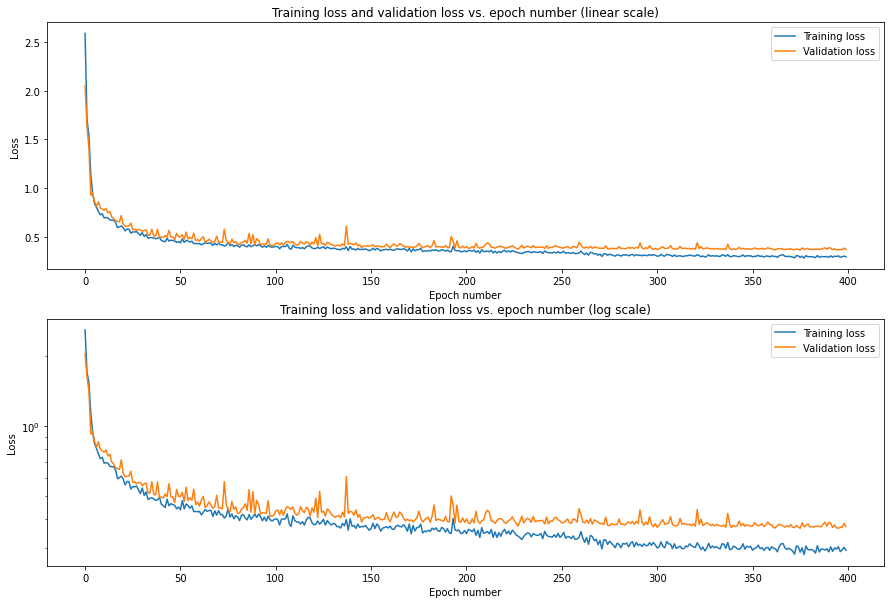

In [5]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(range(400),lossData['loss'], label='Training loss')
plt.plot(range(400),lossData['val_loss'], label='Validation loss')
plt.title('Training loss and validation loss vs. epoch number (linear scale)')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend()

plt.subplot(2,1,2)
plt.semilogy(range(400),lossData['loss'], label='Training loss')
plt.semilogy(range(400),lossData['val_loss'], label='Validation loss')
plt.title('Training loss and validation loss vs. epoch number (log scale)')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend()
plt.show()

lossData.to_csv(output_dir+"training_losses.csv")

Further, we also obtain object level errors using IoU based metrics 

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479034, nms_thresh=0.3.


100%|██████████| 9/9 [00:18<00:00,  2.11s/it]


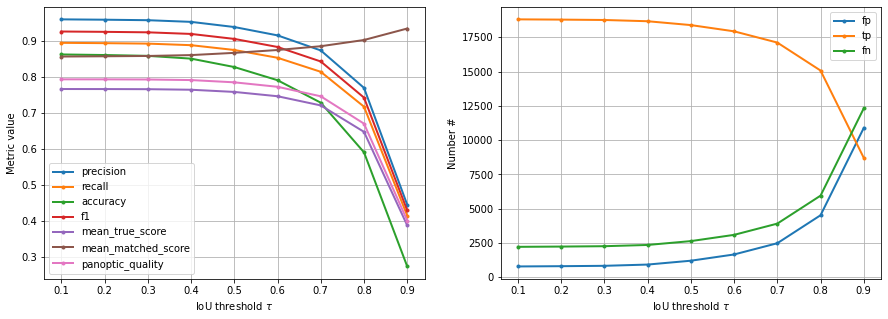

In [6]:
#perform the segmentation task
segment_objects_stardist2d(image_dir = path_to_raw_image,
                           output_dir_labels = path_to_output_segmented_images_train,
                           use_pretrained = False, 
                           output_dir_ijroi = False,
                           model_name='tissue_nuclear_segmentation_2021',
                           model_dir = path_to_model)
#read in the images and results 
X = sorted(glob(path_to_raw_image+"*.tif"))
Y = sorted(glob(path_to_GT_labels+"*.tif"))
Y_pred = sorted(glob(path_to_output_segmented_images_train +"*.tif"))
X = list(map(imread,X))
Y = list(map(imread,Y))
Y_pred = list(map(imread,Y_pred))

#Compute the segmentation efficiency metrics for the whole dataset
#IoU thresholds to compute
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y, Y_pred, thresh=t, show_progress=False) for t in tqdm(taus)]
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
    ax1.set_xlabel(r'IoU threshold $\tau$')
    ax1.set_ylabel('Metric value')
    ax1.grid()
    ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
    ax2.set_xlabel(r'IoU threshold $\tau$')
    ax2.set_ylabel('Number #')
    ax2.grid()
    ax2.legend();
seg_efficiency_tot=pd.DataFrame(stats)
seg_efficiency_tot.to_csv(output_dir+"train_segmentation_efficiencies_whole_dataset.csv")

Finally we use a test dataset of images that the model has not see evaluate the model

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479034, nms_thresh=0.3.


100%|██████████| 9/9 [00:04<00:00,  1.82it/s]


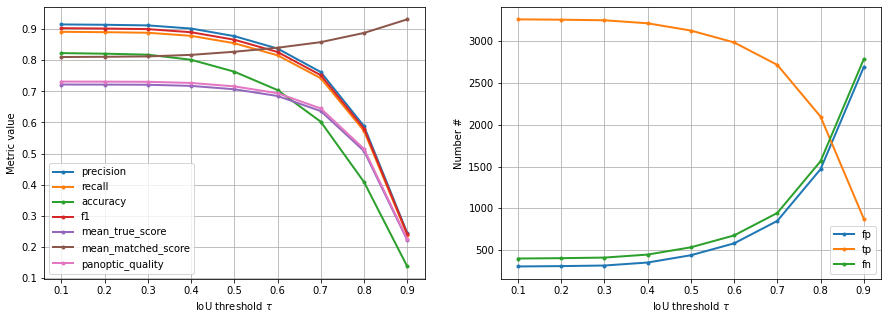

In [7]:
#perform the segmentation task
segment_objects_stardist2d(image_dir = path_to_raw_image_test,
                           output_dir_labels = path_to_output_segmented_images_test,
                           use_pretrained = False,
                           output_dir_ijroi = False,
                           model_name='tissue_nuclear_segmentation_2021',
                           model_dir = path_to_model)
#read in the images and results 
X = sorted(glob(path_to_raw_image_test+"*.tif"))
Y = sorted(glob(path_to_GT_labels_test+"*.tif"))
Y_pred = sorted(glob(path_to_output_segmented_images_test +"*.tif"))
X = list(map(imread,X))
Y = list(map(imread,Y))
Y_pred = list(map(imread,Y_pred))

#Compute the segmentation efficiency metrics for the whole dataset
#IoU thresholds to compute
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y, Y_pred, thresh=t, show_progress=False) for t in tqdm(taus)]
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
    ax1.set_xlabel(r'IoU threshold $\tau$')
    ax1.set_ylabel('Metric value')
    ax1.grid()
    ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
    ax2.set_xlabel(r'IoU threshold $\tau$')
    ax2.set_ylabel('Number #')
    ax2.grid()
    ax2.legend();
#Save the results
seg_efficiency_tot.to_csv(output_dir+"test_segmentation_efficiencies_whole_dataset.csv")

In [8]:
#IoU thresholds to compute
thresholds =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
pd.DataFrame( {"Level" : ['whole_dataset'],
               "Recall_0.7_IoU" : [seg_efficiency_tot['recall'][thresholds.index(0.7)]],
               "Average_F1" : [np.mean(seg_efficiency_tot['f1'])],
               "Accuracy" : [seg_efficiency_tot['accuracy'][thresholds.index(0.7)]]})


,Level,Recall_0.7_IoU,Average_F1,Accuracy
0,whole_dataset,0.813996,0.832901,0.728097
